In [ ]:
import pandas as pd
import os

### LOAD DATA
umsatz_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv"
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv"
kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv"

# Load external data
umsatz_df = pd.read_csv(umsatz_url)
wetter_df = pd.read_csv(wetter_url)
kiwo_df   = pd.read_csv(kiwo_url)
test_df   = pd.read_csv("test.csv",  parse_dates=["Datum"])

umsatz_df['Datum'] = pd.to_datetime(umsatz_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

print("Umsatz columns:", umsatz_df.columns.tolist())
print("Wetter columns:", wetter_df.columns.tolist())
print("KiWo columns:", kiwo_df.columns.tolist())


### MERGE DATA
merged_df = pd.concat([umsatz_df, test_df], axis=0, ignore_index=True)
merged_df = pd.merge(merged_df, wetter_df, on="Datum", how="left")
merged_df = pd.merge(merged_df, kiwo_df, on="Datum", how="left")
merged_df = merged_df.sort_values('Datum')

# Umsatz über alle Warengruppen je Tag summieren
sales_daily_df = merged_df.groupby("Datum")["Umsatz"].sum().reset_index()
sales_daily_df = sales_daily_df.rename(columns={"Umsatz": "sales_daily"})
merged_df = pd.merge(merged_df, sales_daily_df, on="Datum", how="left")
print("Initial merged dataframe shape:", merged_df.shape)
print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())


### MISSING VALUE HANDLING''
merged_df = merged_df.set_index("Datum")
merged_df["Temperatur"] = merged_df["Temperatur"].interpolate(method="time")
merged_df["Windgeschwindigkeit"] = merged_df["Windgeschwindigkeit"].interpolate(method="time")
merged_df["Bewoelkung"] = merged_df["Bewoelkung"].interpolate(method="time")
merged_df = merged_df.reset_index()

# Fill missing values for Kieler
merged_df["KielerWoche"] = merged_df["KielerWoche"].fillna(0)

# Fill missing values for Wettercode
merged_df["Wettercode"] = (merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill"))
# wetter_dummies = pd.get_dummies(merged_df["Wettercode"], prefix="Wetter")
# merged_df = pd.concat([merged_df, wetter_dummies], axis=1)
def simplify_wettercode(code):
    if code in [1, 2, 3, 4]:
        return '1'
    elif code in [20, 21, 22, 23, 24, 25]:
        return '2'
    elif code in [80, 81, 82]:
        return '3'
    elif code in [95, 96, 99]:
        return '4'
    else:
        return '0'

merged_df["Wetterkategorie"] = merged_df["Wettercode"].apply(simplify_wettercode)

# Show the final merged result
print("\nFinal merged dataframe shape:", merged_df.shape)
print("\nFinal columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head())

### ADD NEW VARIABLES
import holidays
de_holidays = holidays.Germany(years=range(2012, 2021))
hol_df = pd.DataFrame(list(de_holidays.items()), columns=["Datum", "Feiertag"]).assign(Datum=lambda df: pd.to_datetime(df["Datum"]),is_holiday=1)
merged_df = pd.merge(merged_df, hol_df[['Datum', 'Feiertag']], on="Datum", how="left")
merged_df["Feiertag"] = merged_df["Feiertag"].fillna("Kein Feiertag")
# distance to next holiday
merged_df["next_holiday"] = merged_df["Datum"].apply(lambda x: min((hol_df["Datum"] - x).abs()) if not hol_df[hol_df["Datum"] > x].empty else pd.Timedelta(days=0))
merged_df["next_holiday"] = merged_df["next_holiday"].dt.days
merged_df["next_holiday"] = merged_df["next_holiday"].apply(lambda x: x**(.5) if x > 0 else 0)
merged_df["next_holiday"] = merged_df["next_holiday"].fillna(0)
merged_df["is_holiday"] = (merged_df["Feiertag"] != "Kein Feiertag").astype(int)
merged_df["Temperatur"] = merged_df["Temperatur"].apply(lambda x: x**(2))
import yfinance as yf1
dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
dax_df = (dax_df.reset_index().rename(columns={'Date': 'Datum','Close': 'DAX_Close'}))
dax_df = dax_df.rename(columns={"^GDAXI": "DAX"})
merged_df = merged_df.merge(dax_df, on="Datum", how="left")
merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))

from astral import sun
from astral import Observer
obs = Observer(latitude=54.3233, longitude=10.1228)
merged_df['day_length_h'] = merged_df['Datum'].dt.date.apply(lambda d: (sun.sun(observer=obs, date=d, tzinfo=None)['sunset'] - sun.sun(observer=obs, date=d, tzinfo=None)['sunrise']).total_seconds() / 3600)

# Warengruppen-Umsätze als Spalten
merged_df["Warengruppe"] = merged_df["Warengruppe"].astype(int)
merged_df_raw = merged_df.copy()

# Pivot-Tabelle: Umsatz je Warengruppe pro Tag
umsatz_pivot = merged_df.pivot_table(
    index="Datum",
    columns="Warengruppe",
    values="Umsatz",
    aggfunc="sum"
)
umsatz_pivot.columns = [f"Warengruppe_{col}" for col in umsatz_pivot.columns]
umsatz_pivot = umsatz_pivot.reset_index()

# Metadaten-Spalten automatisch bestimmen:
# alles, was NICHT Umsatz, Warengruppe, Warengruppen-X oder Datum ist
non_meta_cols = ["Umsatz", "Warengruppe"]
warengruppe_cols = [col for col in merged_df_raw.columns if col.startswith("Warengruppe_")]
meta_cols = [col for col in merged_df_raw.columns if col not in non_meta_cols + warengruppe_cols + ["Datum"]]

# Metadaten je Tag (z. B. Wetter, Feiertag, DAX etc.)
meta_df = merged_df_raw.groupby("Datum")[meta_cols].first().reset_index()

# Merge Umsatz + Metadaten
merged_df = pd.merge(umsatz_pivot, meta_df, on="Datum", how="left")

# sales_daily berechnen und Nullwerte auffüllen
warengruppe_cols = [col for col in merged_df.columns if col.startswith("Warengruppe_")]
merged_df["sales_daily"] = merged_df[warengruppe_cols].sum(axis=1)
merged_df[warengruppe_cols] = merged_df[warengruppe_cols].fillna(0)

merged_df.to_csv("merged_output.csv", index=False)

Umsatz columns: ['id', 'Datum', 'Warengruppe', 'Umsatz']
Wetter columns: ['Datum', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']
KiWo columns: ['Datum', 'KielerWoche']
Initial merged dataframe shape: (11164, 10)

Final merged dataframe shape: (11164, 10)

Final columns: ['id', 'Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'sales_daily']

First few rows:
        id      Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  1307011 2013-07-01            1  148.828353         6.0     17.8375   
1  1307013 2013-07-01            3  201.198426         6.0     17.8375   
2  1307014 2013-07-01            4   65.890169         6.0     17.8375   
3  1307015 2013-07-01            5  317.475875         6.0     17.8375   
4  1307012 2013-07-01            2  535.856285         6.0     17.8375   

   Windgeschwindigkeit  Wettercode  KielerWoche  sales_daily  
0                 15.0        20.0          NaN  

/tmp/ipykernel_2234/1143837883.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["Wettercode"] = (merged_df["Wettercode"].fillna(method="ffill").fillna(method="bfill"))
/tmp/ipykernel_2234/1143837883.py:89: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dax_df = yf1.download("^GDAXI", start="2012-01-01", end="2020-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_2234/1143837883.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df["DAX"] = (merged_df["DAX"].fillna(method="ffill").fillna(method="bfill"))


In [89]:
import pandas as pd
from datetime import datetime

# Load the merged dataset from the first script
merged_df = pd.read_csv("merged_output.csv")

# Convert Datum column to datetime if not already done
merged_df['Datum'] = pd.to_datetime(merged_df['Datum'])

# Define date ranges for splitting
train_start = datetime(2013, 7, 1)
train_end = datetime(2017, 7, 31)
val_start = datetime(2017, 8, 1)
val_end = datetime(2018, 7, 31)
test_start = datetime(2018, 8, 1)
test_end = datetime(2019, 7, 31)

# Split the dataset based on date ranges
train_set = merged_df[(merged_df['Datum'] >= train_start) & 
                      (merged_df['Datum'] <= train_end)].copy()

validation_set = merged_df[(merged_df['Datum'] >= val_start) & 
                          (merged_df['Datum'] <= val_end)].copy()

test_set = merged_df[(merged_df['Datum'] >= test_start) & 
                     (merged_df['Datum'] <= test_end)].copy()

# Save the split datasets
train_set.to_csv("train_set.csv", index=False)
validation_set.to_csv("validation_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
KielerWoche            0
Wetterkategorie        0
next_holiday           0
DAX                    0
day_length_h           0
dtype: int64

VALIDIERUNG:
MSE: 51806.17288629988
R² : 0.27569958864938926

TEST:
MSE: 1000692.8674674566
R² : 0.0
Beispiel-Vorhersagen: [1180.10929746 1216.87692186 1225.78477741 1189.81029511 1138.54120748]
Echte Werte: [0. 0. 0. 0. 0.]


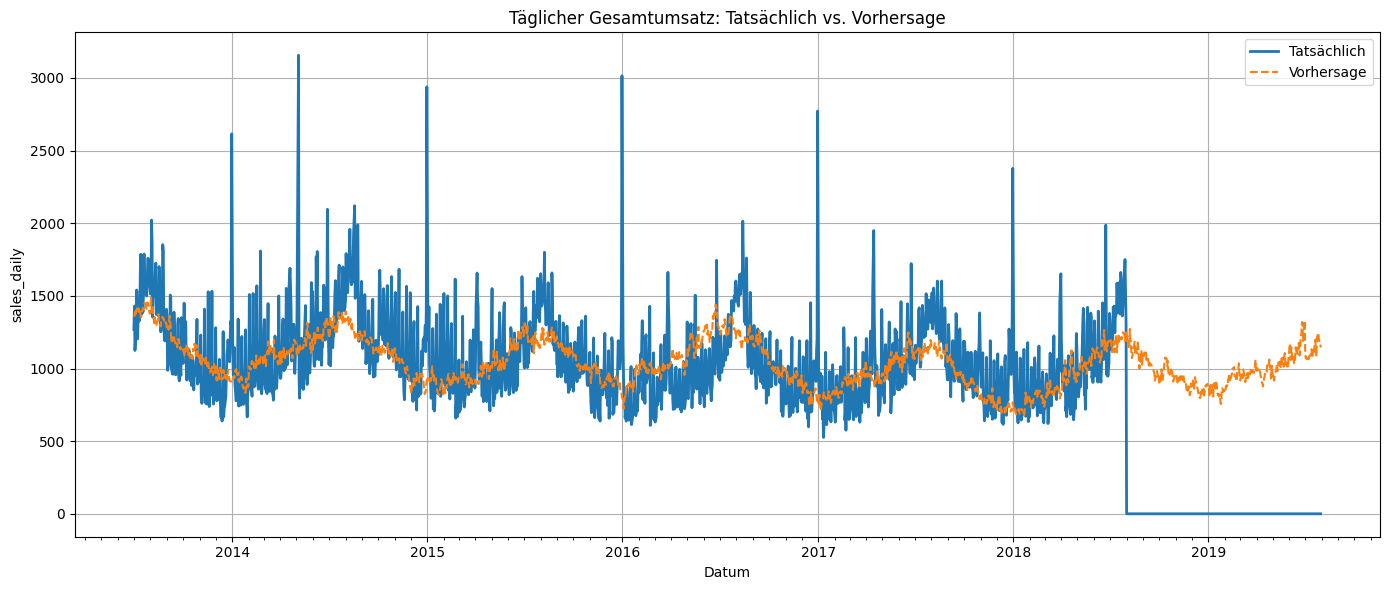

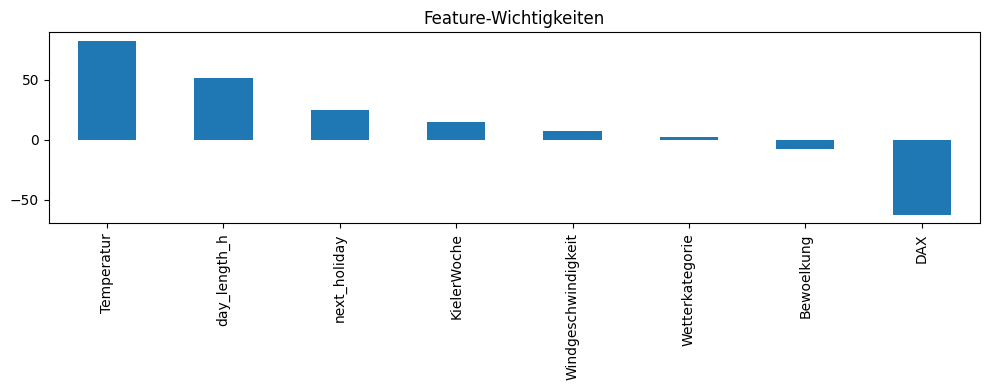

In [90]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

train_set = pd.read_csv("train_set.csv")
validation_set = pd.read_csv("validation_set.csv")
test_set = pd.read_csv("test_set.csv")

# Spalten, die als Eingabe verwendet werden sollen (alle außer Datum & Zielspalte)
exclude_cols = ['id', 'Datum', 'Feiertag', 'sales_daily', 'is_holiday', 'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6', 'Wettercode']  # 'Feiertag' ist nicht numerisch
feature_cols = [col for col in train_set.columns if col not in exclude_cols]

# Zielvariable
target_col = 'sales_daily'

# Features & Targets vorbereiten
X_train = train_set[feature_cols]
y_train = train_set[target_col]

X_val = validation_set[feature_cols]
y_val = validation_set[target_col]

X_test = test_set[feature_cols]
y_test = test_set[target_col]

print(X_train.isna().sum())

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Feature-Gewichtungen direkt nach dem Einlesen und vor dem Skalieren
for df in [X_train, X_val, X_test]:
    df["KielerWoche"] *= 10
    #df["is_holiday"] *= 10000  # HIER aktiv

# Danach skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Vorhersagen
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Bewertung
print("\nVALIDIERUNG:")
print("MSE:", mean_squared_error(y_val, y_val_pred))
print("R² :", r2_score(y_val, y_val_pred))

print("\nTEST:")
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("R² :", r2_score(y_test, y_test_pred))

print("Beispiel-Vorhersagen:", y_test_pred[:5])
print("Echte Werte:", y_test.values[:5])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ursprüngliche Datumsangaben einlesen
train_set["Set"] = "Train"
validation_set["Set"] = "Validation"
test_set["Set"] = "Test"

# Predictions ergänzen
train_set["Prediction"] = model.predict(X_train_scaled)
validation_set["Prediction"] = model.predict(X_val_scaled)
test_set["Prediction"] = model.predict(X_test_scaled)

# Alle zusammenführen
full_df = pd.concat([train_set, validation_set, test_set], axis=0)
full_df = full_df.sort_values("Datum")  # sicherstellen, dass es zeitlich geordnet ist
full_df["Datum"] = pd.to_datetime(full_df["Datum"])

# Plot: tatsächlicher vs. vorhergesagter Verlauf über alle Daten
plt.figure(figsize=(14, 6))
plt.plot(full_df["Datum"], full_df["sales_daily"], label="Tatsächlich", linewidth=2)
plt.plot(full_df["Datum"], full_df["Prediction"], label="Vorhersage", linestyle="--")

# X-Achse: schöner machen
plt.gca().xaxis.set_major_locator(mdates.YearLocator())           # Jährliche Ticks
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())          # Monatliche Unterticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))   # Format: nur Jahr

plt.title("Täglicher Gesamtumsatz: Tatsächlich vs. Vorhersage")
plt.xlabel("Datum")
plt.ylabel("sales_daily")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import numpy as np

weights = pd.Series(model.coef_, index=feature_cols)
weights.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature-Wichtigkeiten")
plt.tight_layout()
plt.show()